## AIM: Validate preprocessing method(s) by checking performance on EC/EO classification

First, features (PSD estimates) will be extracted from the EEG data that was preprocessed with Van Dijk's pipeline.
The feature set will contain calculated PSDs for alpha, beta, delta, gamma, and theta frequency bands for 4 groups of channels (frontal, central, parietal, occipital)
The feature set will then be used to train a classification model that predicts EC/EO condition. Model performance will be evaluated to validate the preprocessing methods.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

In [2]:
# set folder to store the data as working directory
working_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\EC_EO_classification"
os.chdir(working_dir)
os.getcwd()

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\EC_EO_classification'

### Loading in participants data

In [3]:
df_participants = pd.read_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data\df_participants.pkl')
print(df_participants.shape)
df_participants.sample(5)

(714, 12)


,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,diagnosis
141,sub-87966517,DISCOVERY,SMC,UNKNOWN,NaN,71.72,0,1,1,True,True,SMC
1048,sub-88053997,DISCOVERY,MDD,MDD,MDD-rTMS,35.72,1,1,1,True,True,MDD
1018,sub-88052013,DISCOVERY,MDD,MDD,MDD-rTMS,47.21,0,1,1,True,True,MDD
1004,sub-88050169,DISCOVERY,MDD,UNKNOWN,NaN,26.63,1,1,1,True,True,MDD
1269,sub-88073521,DISCOVERY,ADHD,UNKNOWN,NaN,18.59,0,1,1,True,True,ADHD


### Creating montage and info object for PSD calculation with MNE

In [4]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }

# channel groupings (left/mid/right)
l_frontal = ['F3', 'FC3']
m_frontal = ['Fz', 'FCz']
r_frontal = ['F4', 'FC4']
l_central = ['C3', 'CP3']
m_central = ['Cz', 'CPz']
r_central = ['C4', 'CP4']
l_posterior = ['P3', 'O1'] 
m_posterior = ['Pz', 'Oz'] 
r_posterior = ['P4', 'O2'] 
channel_groups = {
    'l_frontal': l_frontal,
    'm_frontal': m_frontal,
    'r_frontal': r_frontal,
    'l_central': l_central,
    'm_central': m_central,
    'r_central': r_central,
    'l_posterior': l_posterior,
    'm_posterior': m_posterior,
    'r_posterior': r_posterior
}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}

## Create montage
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')

# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

# define upper and lower frequencies for each band
delta = [1, 4] # starting at one because of high-pass filter
theta = [4, 8]
alpha = [8, 13]
beta = [13, 30]
gamma = [30, 90] 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}


## Create montage
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')

# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


### Feature extraction from Van Dijk's preprocessed data

In [5]:
# calculate PSD for each file and store in dataframe
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\preprocessed"

df_vandijk = pd.DataFrame() # create empty dataframe to store PSD data

# counter for progress
count = 1
if count == 1:
    total_files = 0
    for _, dirs, files in os.walk(eeg_dir):
        total_files += len([file for file in files if '.npy' in file])

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
            if 'ses-1' in file and '.npy' in file: # filter first session & .npy files
                filepath = os.path.join(subdir, file) # path to eeg file

                # needs specific info object, because has one less channel
                info = mne.create_info(ch_names=ch_names[:32], ch_types=ch_types[:32], sfreq=500)
                info.set_montage(montage=montage, on_missing= 'raise')

                preprocessed_eeg = np.load(filepath, allow_pickle = True)
                raw = mne.io.RawArray(np.squeeze(preprocessed_eeg['data']), info)

                # epoch the data
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0)

                if 'EC' in file:
                    cond = 0
                if 'EO' in file:
                    cond = 1

                # add data to empty dictionary
                psd_dict = {}
                psd_dict['ID'] = [file.split('_')[0]] * epochs.get_data().shape[0]
                psd_dict['EO/EC'] = [cond] * epochs.get_data().shape[0]
                psd_dict['epoch'] = list(range(1, epochs.get_data().shape[0] + 1))
                
                # calculate PSD using Welch's method for each freq band and channel group
                for band in bands:
                    for group in channel_groups:
                        psd_epochs = epochs.compute_psd(method = 'welch', fmin = bands[band][0], fmax = bands[band][1], picks = channel_groups[group], average = 'mean')

                        # compute average spectral spower per epoch per channel group
                        psd_mean = psd_epochs.get_data().mean(axis = (2, 1))

                        psd_dict[f'{group}_{band}'] = psd_mean # add to dictionary
                
                # add to dataframe
                df_vandijk = pd.concat([df_vandijk, pd.DataFrame(psd_dict)], ignore_index = True)

                print(f'\rProgress: {count}/{total_files} files processed.', end = '')
                count += 1
                
df_vandijk.shape
df_vandijk.tail(3)


Progress: 2518/2692 files processed.

,ID,EO/EC,epoch,l_frontal_delta,m_frontal_delta,r_frontal_delta,l_central_delta,m_central_delta,r_central_delta,l_posterior_delta,...,r_posterior_beta,l_frontal_gamma,m_frontal_gamma,r_frontal_gamma,l_central_gamma,m_central_gamma,r_central_gamma,l_posterior_gamma,m_posterior_gamma,r_posterior_gamma
30218,sub-88079017,1,10,7.738213,9.061811,5.461953,5.230726,9.057719,4.051330,3.006873,...,0.448957,0.133040,0.090208,0.130979,0.098440,0.094055,0.099999,0.323396,0.309045,0.231419
30219,sub-88079017,1,11,7.180092,9.160991,5.542110,5.762091,11.426288,5.738385,3.178044,...,0.529666,0.154323,0.100456,0.118271,0.110138,0.106792,0.096753,0.355365,0.327875,0.246205
30220,sub-88079017,1,12,5.596991,4.331443,3.244622,3.158097,5.352553,3.650266,1.890770,...,0.802084,0.184052,0.111969,0.135333,0.128797,0.111832,0.107197,0.385528,0.346483,0.246135


In [6]:
print(df_vandijk.shape)

(30221, 48)


In [7]:
df_vandijk.to_pickle('df_vandijk_psds.pkl')

## Classification models:

In [5]:
df_vandijk = pd.read_pickle('df_vandijk_psds.pkl')

SPLIT 1
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   72    73    74 ... 30098 30099 30100]

Length train: 24174, Length test: 6047

SPLIT 2
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   48    49    50 ... 30194 30195 30196]

Length train: 24176, Length test: 6045

SPLIT 3
TRAIN INDEXES: [    0     1     2 ... 30218 30219 30220], TEST INDEXES: [   96    97    98 ... 30122 30123 30124]

Length train: 24176, Length test: 6045

SPLIT 4
TRAIN INDEXES: [   24    25    26 ... 30218 30219 30220], TEST INDEXES: [    0     1     2 ... 30146 30147 30148]

Length train: 24173, Length test: 6048

SPLIT 5
TRAIN INDEXES: [    0     1     2 ... 30194 30195 30196], TEST INDEXES: [   24    25    26 ... 30218 30219 30220]

Length train: 24185, Length test: 6036

cv_scores mean acc:0.7466941279180789

cv_scores std acc:0.015741698111197102

cv_scores acc: [0.73441376 0.73382961 0.75715467 0.77281746 0.73525514]

cv_scores mean f1:0.7559466963666

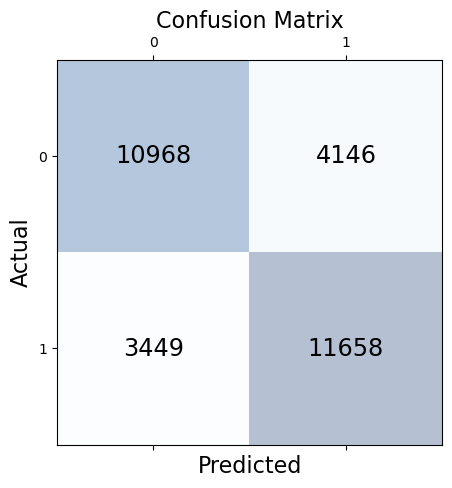

In [6]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data

## Random Forest for EO/ EC classification, sk learn Pipeline for StandardScaler().
## GroupKFold is a variation of KFold that makes sure that predefined underlying groups (here: participants) 
## in the data do not appear in both train and test set in the same fold. 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing

## Prevent warning printing
import warnings
warnings.filterwarnings("ignore")

## Set random seed
random_seed  = 333

## Assign numeric columns
numeric_cols = []
for band in bands:
    for group in channel_groups:
        numeric_cols.append(f'{group}_{band}')


## Assign groups for GroupKFold
groups = np.array(df_vandijk['ID'].values)

## Specify cross-validation iterator 
gkf = GroupKFold(5)

## Specify classifier
rf = RandomForestClassifier()

## Get features and target arrays
def get_features_and_target_arrays(df, numeric_cols):
    x_numeric_scaled = df[numeric_cols]
#     x_categorical = df[cat_cols].to_numpy()
#     X = np.hstack((x_categorical, x_numeric_scaled))
    X = x_numeric_scaled
    y = df['EO/EC'].values
    return X, y

## X and y
X, y = get_features_and_target_arrays(df_vandijk, numeric_cols)

## Make Pipeline
classifier_pipeline = make_pipeline(preprocessing.StandardScaler(), rf)

## Print splits
for split, (ix_train, ix_test) in enumerate(gkf.split(X, groups=groups)):
    
    print(f'SPLIT {split+1}')
    print(f'TRAIN INDEXES: {ix_train}, TEST INDEXES: {ix_test}\n')
    print(f'Length train: {len(ix_train)}, Length test: {len(ix_test)}\n')


## Define scores
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
## CrossValidation scores
cv_scores = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = 'accuracy')
cv_scores_f1 = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(f1_score))
cv_scores_recall = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(recall_score))
cv_scores_precision = cross_val_score(classifier_pipeline, X, y, cv = gkf, groups = groups, scoring = make_scorer(precision_score))

## Print CrossValidation scores per fold (accuracy and f1)
print('cv_scores mean acc:{}'.format(np.mean(cv_scores)))
print()
print('cv_scores std acc:{}'.format(np.std(cv_scores)))
print()
print('cv_scores acc:', cv_scores)
print()
print('cv_scores mean f1:{}'.format(np.mean(cv_scores_f1)))
print()
print('cv_scores std f1:{}'.format(np.std(cv_scores_f1)))
print()
print('cv_scores f1:', cv_scores_f1)

## Print CrossValidation scores (accuracy and f1)
print('cv_scores mean precision:{}'.format(np.mean(cv_scores_precision)))
print()
print('cv_scores std precision:{}'.format(np.std(cv_scores_precision)))
print()
print('cv_scores precision:', cv_scores_precision)
print()
print('cv_scores mean recall:{}'.format(np.mean(cv_scores_recall)))
print()
print('cv_scores std recall:{}'.format(np.std(cv_scores_recall)))
print()
print('cv_scores recall:', cv_scores_recall)

## Print F1-score and classification report
y_pred = cross_val_predict(classifier_pipeline, X, y,  cv = gkf, groups = groups)    
print('f1_score:', f1_score(y, y_pred))
print()
print('classification report:\n', classification_report(y, y_pred))

## Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

Features sorted by their score for estimator 0:


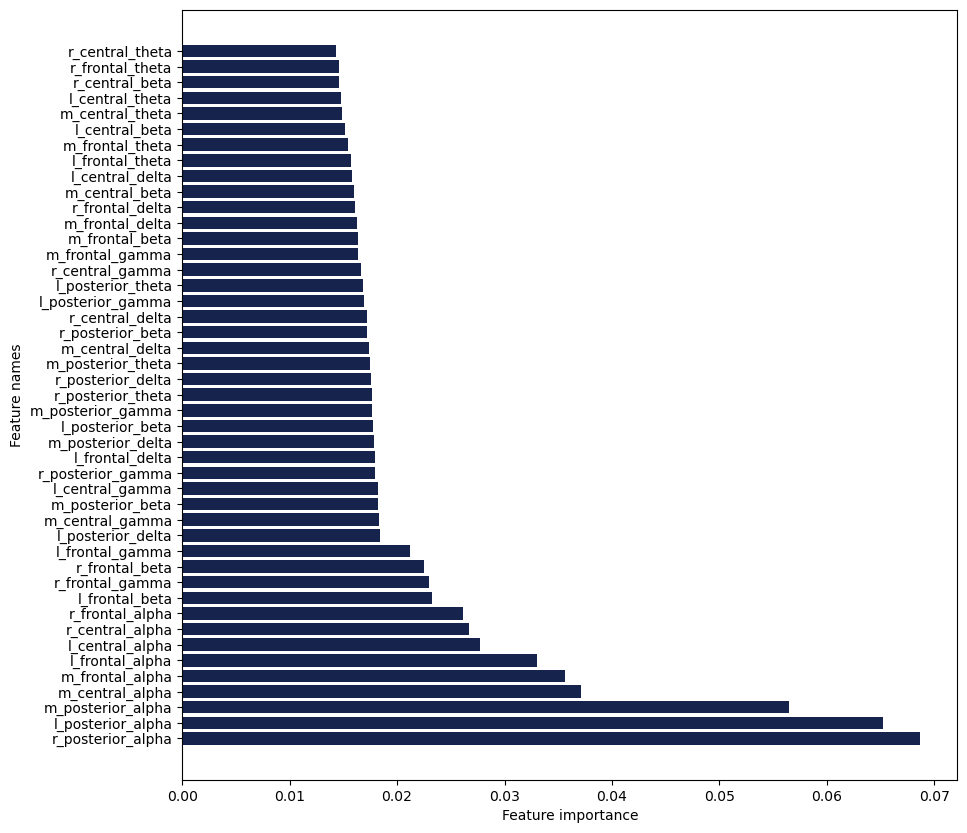

Features sorted by their score for estimator 1:


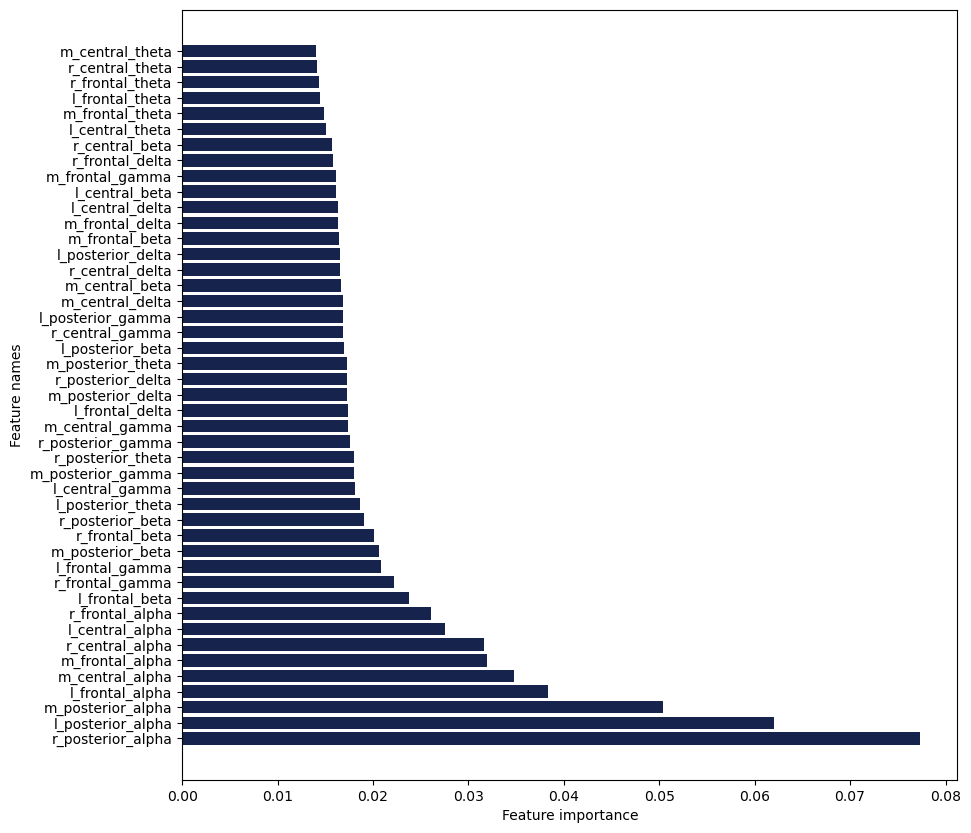

Features sorted by their score for estimator 2:


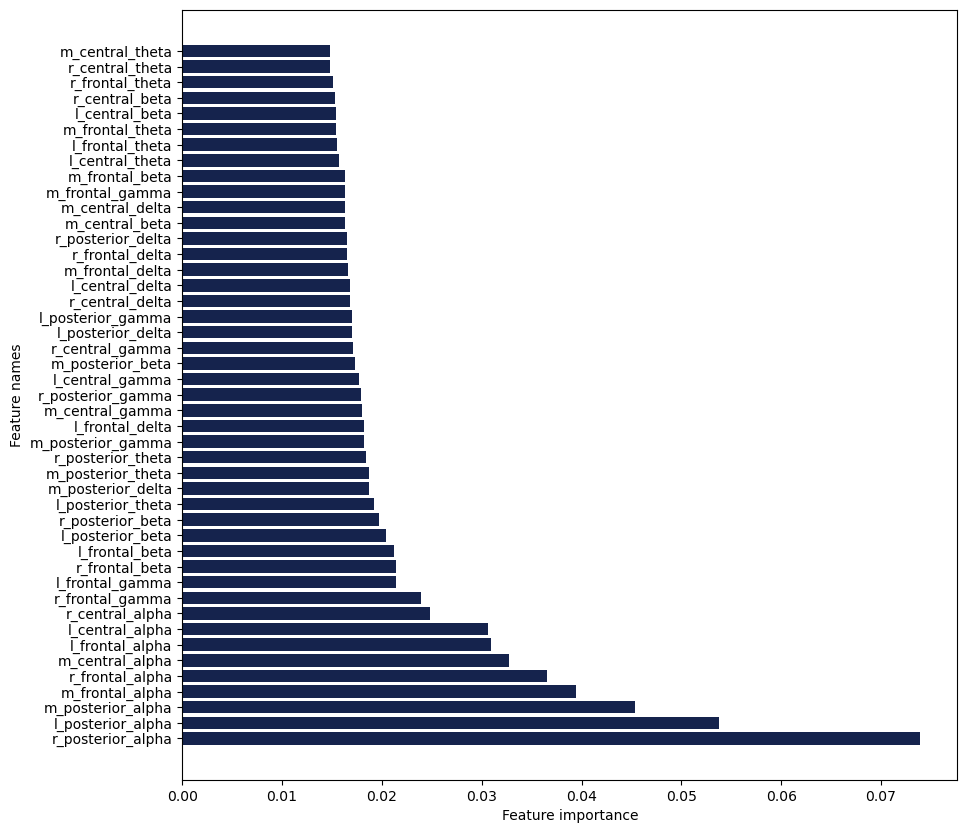

Features sorted by their score for estimator 3:


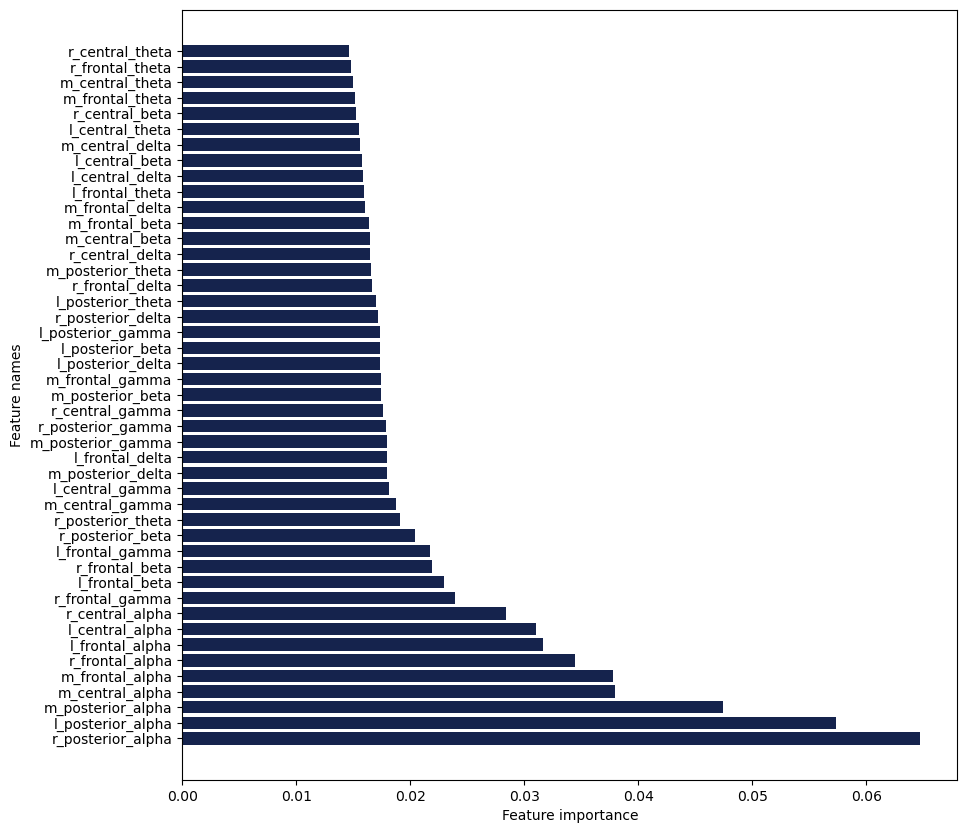

Features sorted by their score for estimator 4:


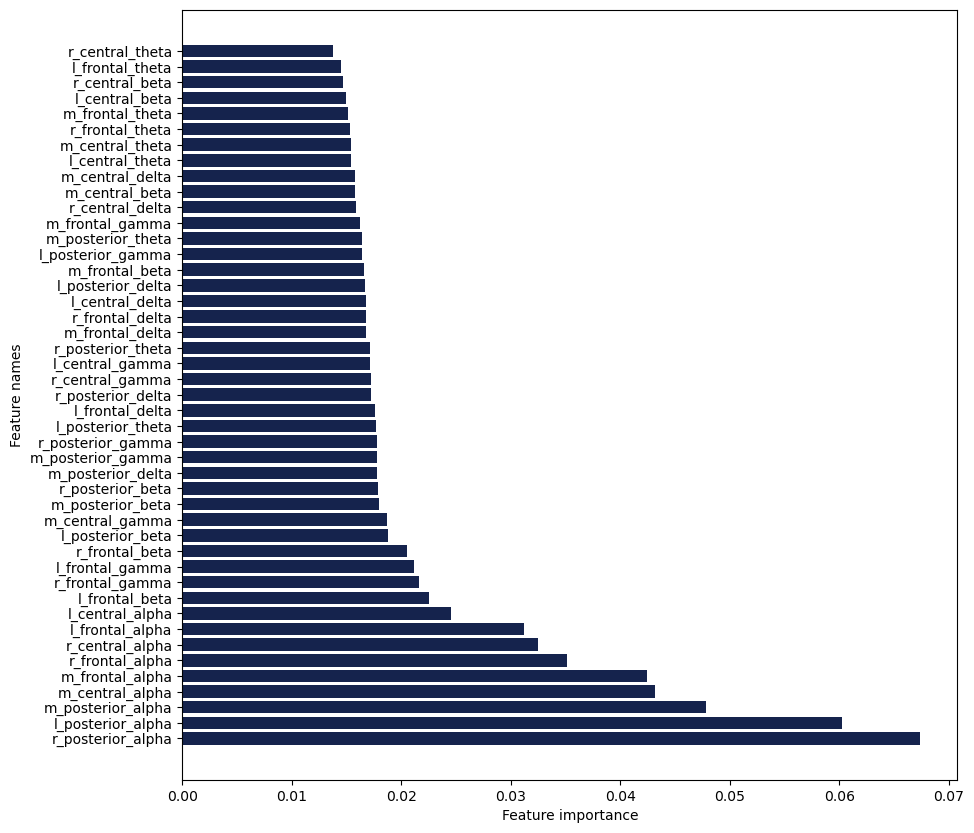

In [8]:
### Code from Anne van Duijvenbode, but slightly adjusted to fit the current data:

## Feature importance
output = cross_validate(classifier_pipeline, X, y, cv = gkf, scoring = 'accuracy', return_estimator = True, groups = groups)
feature_names = numeric_cols

## Get feature importances
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(list(zip(estimator[-1].feature_importances_, feature_names)),
                                       columns=['importance', 'feature_names']).sort_values('importance', ascending = False)
    #print(feature_importances)
    
    ## Plot feature importances
#     feature_importances.sort(key = lambda x : x[1])
    plt.figure(figsize=(10, 10))
    plt.barh(feature_importances['feature_names'], feature_importances['importance'], color = '#15234d')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

    plt.show()

In [87]:
del df_vandijk # remove dataframe from memory